In this tutorial, we learn to use the convenient `get_cdr_mask` method of `AntibodyStructureBatch` to select CDRs from an antibody structure.

In [1]:
from protstruc import AntibodyStructureBatch
from protstruc.general import ATOM

import matplotlib.pyplot as plt
import py3Dmol

## Highlighting CDRs with `get_cdr_mask`

We'll deal with two antibody structures:

- The first one is an murine antibody Fab structure binding to a component of a potassium channel complex (PDB ID: [4UUJ](https://www.rcsb.org/structure/4uuj)).
- The second one is a human respiratory syncytial virus (RSV)-neutralizing antibody Fab structure without an antigen. (PDB ID: [6DC4](https://www.rcsb.org/structure/6dc4)).

In [2]:
pdb_paths = ['4uuj.pdb', '6dc4.pdb']
heavy_chain_id = ['A', 'H']
light_chain_id = ['B', 'L']
antigen_chain_ids = [['C'], None]  # no antigen for 6cd4

First, to take a quick glance at their structures, let's use a handy `py3Dmol` library to interactively visualize them in the notebook.

In [3]:
def visualize_antibody(
    pdb_fp,
    heavy_chain_id,
    light_chain_id,
    antigen_chain_ids = None,
    view_args={'width': 400, 'height': 400}
):
    with open(pdb_fp) as f:
        protein = ''.join([x for x in f])

    view = py3Dmol.view(**view_args)
    view.addModel(protein, 'pdb')

    view.setStyle({'chain': heavy_chain_id}, {'cartoon': {'color': 'cyan'}})
    view.setStyle({'chain': light_chain_id}, {'cartoon': {'color': 'magenta'}})
    if antigen_chain_ids is not None:
        for chid in antigen_chain_ids:
            view.setStyle({'chain': chid}, {'cartoon': {'color': 'grey'}})
    view.zoomTo()

    view.spin({'x': 2, 'y': 1.5, 'z': 1}, 0.5)
    view.show()

In [4]:
visualize_antibody(
    '4uuj.pdb', 'A', 'B', 'C',
    view_args={'width': 300, 'height': 300}
)
visualize_antibody(
    '6dc4.pdb', 'H', 'L', None,
    view_args={'width': 300, 'height': 300}
)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Initializing an `AntibodyStructureBatch`

Next, let's initialize an `AntibodyStructureBatch` from the two pdb files we visualized above.

Note that we use a **renumbered** antibody PDB files (downloaded from SAbDab database) as input. Among a handful of renumbering schemes out there, here we choose **"Chothia"** numbering scheme.

Also note the `keep_fv_only` parameter. If this parameter is `True`, the parser discards the constant domains of Fab structures and only keeps the variable domains. 

In [5]:
asb = AntibodyStructureBatch.from_pdb(
    pdb_paths, heavy_chain_id, light_chain_id, antigen_chain_ids,
    numbering_scheme='chothia', keep_fv_only=False
)

## Visualizing the all-atom cloud

That's it! Now you can check if the structure is correctly initialized. We are going to highlight and see the structural properties of CDRs using `get_cdr_mask` method.

First, let's have a tensor of all-atom coordinates using `get_xyz` method and only focus on our first protein `4uuj`.

In [6]:
prt_idx = 0  # only deal with the first protein

The all-atom cloud of the protein looks like this:

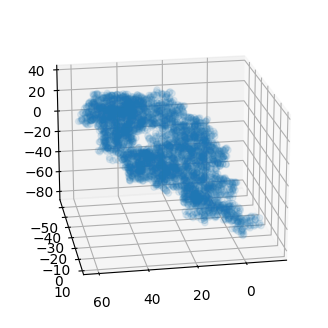

In [7]:
xyz = asb.get_xyz()  # batch_size x n_residues x n_atoms x 3
xyz_mask = asb.get_atom_mask().bool()  # batch_size x n_residues x n_atoms

xyz, xyz_mask = xyz[prt_idx], xyz_mask[prt_idx]

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    xyz[xyz_mask][:, 0],
    xyz[xyz_mask][:, 1],
    xyz[xyz_mask][:, 2],
    alpha=0.1,
)
ax.view_init(20, 80)

## Coloring by chain identity

What if we want to give different colors to different chains? We can retrieve some masks using `get_heavy_chain_mask`, `get_light_chain_mask` and `get_antigen_mask`, select those atoms and give them separate colors.

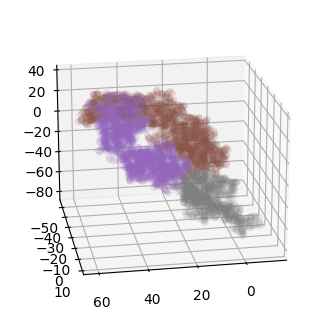

In [8]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection="3d")

# obtain a boolean mask for each of the chains
h_mask = asb.get_heavy_chain_mask()[prt_idx]
l_mask = asb.get_light_chain_mask()[prt_idx]
ag_mask = asb.get_antigen_mask()[prt_idx]

masks = [h_mask, l_mask, ag_mask]
colors = ['C4', 'C5', 'C7']
for mask, c in zip(masks, colors):
    xyz_masked = xyz[mask][xyz_mask[mask]]

    ax.scatter(
        xyz_masked[:, 0],
        xyz_masked[:, 1],
        xyz_masked[:, 2],
        c=c,
        alpha=0.1,
    )

ax.view_init(20, 80)

## Highlighting CDRs

Finally, we can additionally highlight the CDRs in the structure using `get_cdr_mask` method. You can easily see the CDRs (red) bound to the antigen (grey).

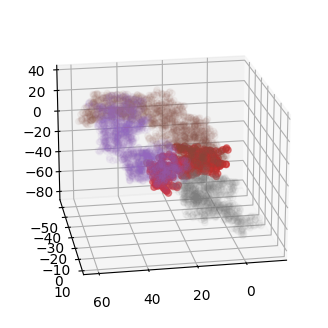

In [9]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection="3d")

# obtain a boolean mask for each of the chains
h_mask = asb.get_heavy_chain_mask()[prt_idx]
l_mask = asb.get_light_chain_mask()[prt_idx]
ag_mask = asb.get_antigen_mask()[prt_idx]

masks = [h_mask, l_mask, ag_mask]
colors = ['C4', 'C5', 'C7']
for mask, c in zip(masks, colors):
    xyz_masked = xyz[mask][xyz_mask[mask]]

    ax.scatter(
        xyz_masked[:, 0],
        xyz_masked[:, 1],
        xyz_masked[:, 2],
        c=c,
        alpha=0.05,
    )

cdrs = ['H1', 'H2', 'H3', 'L1', 'L2', 'L3']
for cdr in cdrs:
    # `get_cdr_mask(subset)` returns a boolean mask for
    # the corresponding CDRs.
    cdr_mask = asb.get_cdr_mask(cdr)[prt_idx]

    xyz_masked = xyz[cdr_mask][xyz_mask[cdr_mask]]
    ax.scatter(
        xyz_masked[:, 0],
        xyz_masked[:, 1],
        xyz_masked[:, 2],
        c='C3',
        alpha=0.5,
    )

ax.view_init(20, 80)

More precisely, we can only visualize Ca atoms like this:

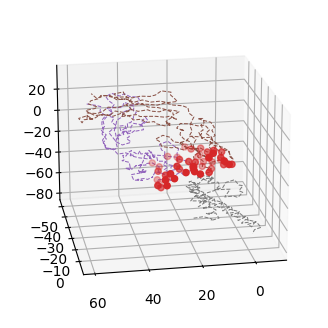

In [10]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection="3d")

# obtain a boolean mask for each of the chains
h_mask = asb.get_heavy_chain_mask()[prt_idx]
l_mask = asb.get_light_chain_mask()[prt_idx]
ag_mask = asb.get_antigen_mask()[prt_idx]

masks = [h_mask, l_mask, ag_mask]
colors = ['C4', 'C5', 'C7']
for mask, c in zip(masks, colors):
    xyz_masked = xyz[mask, ATOM.CA]

    ax.plot(
        xyz_masked[:, 0],
        xyz_masked[:, 1],
        xyz_masked[:, 2],
        c=c,
        ls='--',
        lw=0.75,
    )

cdrs = ['H1', 'H2', 'H3', 'L1', 'L2', 'L3']
for cdr in cdrs:
    # `get_cdr_mask(subset)` returns a boolean mask for
    # the corresponding CDRs.
    cdr_mask = asb.get_cdr_mask(cdr)[prt_idx]

    xyz_masked = xyz[cdr_mask, ATOM.CA]
    ax.scatter(
        xyz_masked[:, 0],
        xyz_masked[:, 1],
        xyz_masked[:, 2],
        c='C3',
    )

ax.view_init(20, 80)